In [1]:
# Import Required Libraries
import pandas as pd

In [2]:
# Importing all necessary libraries for topic modeling and sentiment analysis
import urllib.request
import os
import joblib
import pickle
import pandas as pd
import numpy as np
import re
import ast
import textwrap
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Set visual styles for the whole notebook
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
%matplotlib inline

warnings.filterwarnings('ignore')

# Download NLTK resources if not already present
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Loading the dataset from the classroom URL
url = "https://raw.githubusercontent.com/course-files/NaturalLanguageProcessing/refs/heads/main/data/202511-ft_bi1_bi2_course_evaluation.csv"
df = pd.read_csv(url)
df.head()

,timestamp,consent,a_1_student_id,a_2_gender,a_3_class_group,b_1_i_enjoyed_the_course,b_2_classes_started_and_ended_on_time,b_3_participative_learning_environment,b_4_subject_content_delivered_according_to_course_outline_and_my_expectations,b_5_topics_were_clear_and_logically_developed,...,f_1_In_your_opinion_which_topics_(if_any)_should_be_added_to_the_Business_Intelligence_I_and_II_curriculum,f_2_In_your_opinion_which_topics_(if_any)_should_be_removed_from_the_Business_Intelligence_I_and_II_curriculum,f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course,f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes),average_course_evaluation_rating,sentiment,average_level_of_learning_attained_rating,average_level_of_skills_and_competencies_rating,average_pedagogical_strategy_effectiveness_rating,absenteeism_percentage
0,06-11-25 8:19,I CONSENT to my feedback being analyzed and us...,1,Male,Group A,5,5,5,5,5,...,NaN,NaN,The teacher was engaging,More group time to work on group activities,4.9091,positive,4.000,1.6923,4.0833,40.91
1,06-11-25 8:20,I CONSENT to my feedback being analyzed and us...,2,Male,Group A,5,5,5,5,5,...,Nothing,NaN,Teaching was on time,More quizes,5.0000,positive,5.000,4.0000,4.0000,9.09
2,06-11-25 8:21,I CONSENT to my feedback being analyzed and us...,3,Male,Group A,3,4,3,4,4,...,NaN,NaN,Well detailed notes\nWell explained concepts,More clear instructions given out during the l...,3.4545,negative,3.000,3.0000,3.5833,13.64
3,06-11-25 8:21,I CONSENT to my feedback being analyzed and us...,4,Male,Group A,4,4,4,4,4,...,NaN,NaN,The Lab works and Quizes,More engaging lessons,3.6364,negative,4.375,4.6154,4.3333,13.64
4,06-11-25 8:23,I CONSENT to my feedback being analyzed and us...,5,Male,Group A,5,5,5,5,5,...,NaN,NaN,Interactive teaching and use of analogies,Everything's seemingly fine,4.6364,positive,4.250,2.1538,2.7500,18.18


In [8]:
# Initialize NLP tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    # Lowercase conversion
    text = str(text).lower()
    # Remove special characters/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = nltk.word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    # Apply stemming
    stemmed = [stemmer.stem(word) for word in filtered]
    return " ".join(stemmed)

# Clean each open-ended column separately
col_liked = 'f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course'
col_recommend = 'f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes)'
df['clean_liked'] = df[col_liked].apply(clean_text)
df['clean_recommendation'] = df[col_recommend].apply(clean_text)

# Combine both cleaned columns into one for modeling
# (handles missing values by filling with empty string)
df['clean_text_combined'] = df['clean_liked'].fillna('') + ' ' + df['clean_recommendation'].fillna('')

# Preview the result
df[[col_liked, col_recommend, 'clean_liked', 'clean_recommendation', 'clean_text_combined']].head()

,f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course,f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes),clean_liked,clean_recommendation,clean_text_combined
0,The teacher was engaging,More group time to work on group activities,teacher engag,group time work group activ,teacher engag group time work group activ
1,Teaching was on time,More quizes,teach time,quiz,teach time quiz
2,Well detailed notes\nWell explained concepts,More clear instructions given out during the l...,well detail note well explain concept,clear instruct given lab work,well detail note well explain concept clear in...
3,The Lab works and Quizes,More engaging lessons,lab work quiz,engag lesson,lab work quiz engag lesson
4,Interactive teaching and use of analogies,Everything's seemingly fine,interact teach use analog,everyth seemingli fine,interact teach use analog everyth seemingli fine


In [9]:
# Feature Extraction: TF-IDF Vectorization on the combined cleaned text
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))  # You can adjust max_features/ngrams as needed
X_tfidf = vectorizer.fit_transform(df['clean_text_combined'])

# Show the shape and a preview of the feature matrix
display(pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out()).head())
print(f"TF-IDF feature matrix shape: {X_tfidf.shape}")

,abl achiev,abstract,abstract theori,abt,abt complet,access,access note,achiev,achiev work,across,...,would industri,would instantli,would like,would nice,would probabl,would recommend,would stop,write,year,year allow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


TF-IDF feature matrix shape: (130, 1000)


In [10]:
# Topic Modeling using Latent Dirichlet Allocation (LDA)
from sklearn.decomposition import LatentDirichletAllocation

# Set the number of topics (you can adjust this based on your data)
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_topics = lda.fit_transform(X_tfidf)

# Display top words for each topic
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

display_topics(lda, vectorizer.get_feature_names_out())

# Assign the dominant topic to each document
df['dominant_topic'] = lda_topics.argmax(axis=1) + 1  # +1 for 1-based topic numbering
df[['clean_text_combined', 'dominant_topic']].head()

Topic 1:
work group group work lab like modul assign learn slide quizz

Topic 2:
slide note use lab teach content deliveri concept deliveri okay like

Topic 3:
lab cat better help busi detail less work difficult content

Topic 4:
lab nan practic lectur lab work like journal work help modul

Topic 5:
unit applic practic lab learn lectur nan real bi real life



,clean_text_combined,dominant_topic
0,teacher engag group time work group activ,1
1,teach time quiz,4
2,well detail note well explain concept clear in...,2
3,lab work quiz engag lesson,5
4,interact teach use analog everyth seemingli fine,1


In [12]:
# Load pre-trained sentiment model and vectorizer from 2_sentiment_analysis
import joblib

# Load the trained sentiment classifier and vectorizer
sentiment_model = joblib.load('./model/sentiment_classifier.pkl')
vectorizer = joblib.load('./model/topic_vectorizer_using_tfidf.pkl')

# Vectorize the cleaned text using the loaded vectorizer
X_new = vectorizer.transform(df['clean_text_combined'])

# Predict sentiment for each response
df['predicted_sentiment'] = sentiment_model.predict(X_new)

df[['clean_text_combined', 'predicted_sentiment']].head()

,clean_text_combined,predicted_sentiment
0,teacher engag group time work group activ,positive
1,teach time quiz,positive
2,well detail note well explain concept clear in...,positive
3,lab work quiz engag lesson,positive
4,interact teach use analog everyth seemingli fine,positive


In [6]:
# Check the actual column names and preview the data
display(df.head())
print("\nColumns:", df.columns.tolist())

,timestamp,consent,a_1_student_id,a_2_gender,a_3_class_group,b_1_i_enjoyed_the_course,b_2_classes_started_and_ended_on_time,b_3_participative_learning_environment,b_4_subject_content_delivered_according_to_course_outline_and_my_expectations,b_5_topics_were_clear_and_logically_developed,...,f_1_In_your_opinion_which_topics_(if_any)_should_be_added_to_the_Business_Intelligence_I_and_II_curriculum,f_2_In_your_opinion_which_topics_(if_any)_should_be_removed_from_the_Business_Intelligence_I_and_II_curriculum,f_3_Write_at_least_two_things_you_liked_about_the_teaching_and_learning_in_this_course,f_4_Write_at_least_one_recommendation_to_improve_the_teaching_and_learning_in_this_course_(for_future_classes),average_course_evaluation_rating,sentiment,average_level_of_learning_attained_rating,average_level_of_skills_and_competencies_rating,average_pedagogical_strategy_effectiveness_rating,absenteeism_percentage
0,06-11-25 8:19,I CONSENT to my feedback being analyzed and us...,1,Male,Group A,5,5,5,5,5,...,NaN,NaN,The teacher was engaging,More group time to work on group activities,4.9091,positive,4.000,1.6923,4.0833,40.91
1,06-11-25 8:20,I CONSENT to my feedback being analyzed and us...,2,Male,Group A,5,5,5,5,5,...,Nothing,NaN,Teaching was on time,More quizes,5.0000,positive,5.000,4.0000,4.0000,9.09
2,06-11-25 8:21,I CONSENT to my feedback being analyzed and us...,3,Male,Group A,3,4,3,4,4,...,NaN,NaN,Well detailed notes\nWell explained concepts,More clear instructions given out during the l...,3.4545,negative,3.000,3.0000,3.5833,13.64
3,06-11-25 8:21,I CONSENT to my feedback being analyzed and us...,4,Male,Group A,4,4,4,4,4,...,NaN,NaN,The Lab works and Quizes,More engaging lessons,3.6364,negative,4.375,4.6154,4.3333,13.64
4,06-11-25 8:23,I CONSENT to my feedback being analyzed and us...,5,Male,Group A,5,5,5,5,5,...,NaN,NaN,Interactive teaching and use of analogies,Everything's seemingly fine,4.6364,positive,4.250,2.1538,2.7500,18.18



Columns: ['timestamp', 'consent', 'a_1_student_id', 'a_2_gender', 'a_3_class_group', 'b_1_i_enjoyed_the_course', 'b_2_classes_started_and_ended_on_time', 'b_3_participative_learning_environment', 'b_4_subject_content_delivered_according_to_course_outline_and_my_expectations', 'b_5_topics_were_clear_and_logically_developed', 'b_6_developed_my_oral_and_writing_skills', 'b_7_developed_my_reflective_and_critical_reasoning_skills', 'b_8_the_assessment_methods_assisted_me_to_learn', 'b_9_received_relevant_feedback', 'b_10_read_recommended_readings_and_notes', 'b_11_used_the_elearning_material_posted', 'c_1_principles_of_business_intelligence_and_the_dataops_philosophy', 'c_2_data_engineering_and_data_analytics', 'c_3_dashboarding_for_business-facing_and_customer-facing_analytics', 'c_4_regression_and_classification', 'c_5_clustering_and_association_rule_mining', 'c_6_serving_ml_models_through_a_restish_api_using_flask_in_python', 'c_7_time-series_analysis_time-series_forecasting_and_neural_

Classification Report:
                     precision    recall  f1-score   support

           negative       0.00      0.00      0.00         0
            neutral       0.00      0.00      0.00         0
neutral_or_negative       0.00      0.00      0.00       103
           positive       0.21      0.96      0.34        27

           accuracy                           0.20       130
          macro avg       0.05      0.24      0.08       130
       weighted avg       0.04      0.20      0.07       130



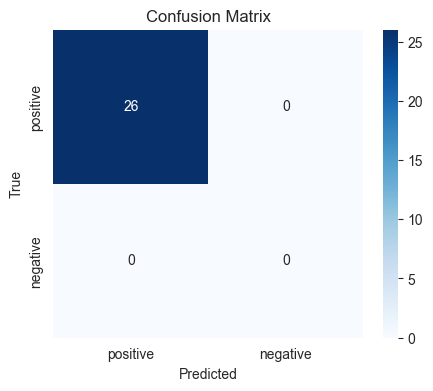

In [15]:
# Evaluate sentiment model performance using true labels
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# True labels from the dataset
y_true = df['sentiment']
# Model predictions from the DataFrame
y_pred = df['predicted_sentiment']

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['positive', 'negative'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Retrain sentiment model to include all classes in the data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import joblib

# Use the cleaned combined text and the original sentiment column
X = df['clean_text_combined']
y = df['sentiment']

# Split data (optional, for validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit a new TF-IDF vectorizer on the training data
vectorizer_new = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_train_tfidf = vectorizer_new.fit_transform(X_train)
X_test_tfidf = vectorizer_new.transform(X_test)

# Train a new Logistic Regression model
clf_new = LogisticRegression(max_iter=1000, random_state=42)
clf_new.fit(X_train_tfidf, y_train)

# Evaluate on the test set
y_pred_new = clf_new.predict(X_test_tfidf)
print('Classification Report (all classes):')
print(classification_report(y_test, y_pred_new))

# Save the new model and vectorizer
joblib.dump(clf_new, './model/sentiment_classifier_all_classes.pkl')
joblib.dump(vectorizer_new, './model/topic_vectorizer_all_classes.pkl')

Classification Report (all classes):
                     precision    recall  f1-score   support

neutral_or_negative       0.81      1.00      0.89        21
           positive       0.00      0.00      0.00         5

           accuracy                           0.81        26
          macro avg       0.40      0.50      0.45        26
       weighted avg       0.65      0.81      0.72        26



['./model/topic_vectorizer_all_classes.pkl']

# Project Work: Topic Modeling and Sentiment Analysis

This notebook will guide you through loading the course evaluation dataset, preprocessing, topic modeling, and sentiment analysis.